## Summary of the notebook

## Mount the drive

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting the correct path

In [ ]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'deep_ensemble'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/


## Removing previous trained models

In [ ]:
import os
import shutil

test = os.listdir(path)

for item in test:
    if '.h5' in item:
        print(f'deleting {item}')
        shutil.rmtree(path+item)
    else:
        pass
        

## Imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.0
Eager execution enabled : False


## regression_nll_loss

In [ ]:
import tensorflow as tf 

def regression_gaussian_nll_loss(variance_tensor, epsilon=1e-8, variance_logits=False):
    """
        Gaussian negative log-likelihood for regression, with variance estimated by the model.
        This function returns a keras regression loss, given a symbolic tensor for the sigma square output of the model.
        The training model should return the mean, while the testing/prediction model should return the mean and variance.
    """
    def nll(y_true, y_pred):
        #if variance_logits:
        #    variance_tensor = K.exp(variance_tensor)

        return 0.5 * tf.math.reduce_mean(tf.math.log(variance_tensor + epsilon) + tf.math.square(y_true - y_pred) / (variance_tensor + epsilon))

    return nll

## Load data

In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()
print(train_labels[20])
print(val_labels[30])
print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)
[0.1816508]
[0.25773296]
[0.12732958]


## DeepEnsemble 

In [ ]:
import keras 
METADATA_FILENAME = "metadata.yml"

class DeepEnsemble:
    def __init__(self, model_fn=None, num_estimators=None, models=None, needs_test_estimators=False):
        self.needs_test_estimators = needs_test_estimators
        self.model_fn = model_fn
        self.num_estimators = num_estimators
        self.models = models

        if models is None:
            assert model_fn is not None and num_estimators is not None
            assert num_estimators > 0
            
            self.num_estimators = num_estimators
            self.train_estimators = [None] * num_estimators 
            self.test_estimators = [None] * num_estimators

            print('train_estimators ', self.train_estimators)
            print('test_estimators ', self.test_estimators)
            print('num_estimators ', self.num_estimators)
            

            for i in range(self.num_estimators):
                if self.needs_test_estimators:
                    estimators = model_fn()

                    if type(estimators) is not tuple:
                        raise ValueError("model_fn should return a tuple")

                    if len(estimators) != 2:
                        raise ValueError("model_fn returned a tuple of unexpected size ({} vs 2)".format(len(estimators)))

                    train_est, test_est = estimators
                    self.train_estimators[i] = train_est
                    self.test_estimators[i] = test_est
                else:
                    est = model_fn()
                    print('len of est ', len(est))
                    self.train_estimators[i] = est[0]
                    self.test_estimators[i] = est[1]
                    #print(f'train_estimators[{i}] : {est}')
                    #print(f'test_estimators[{i}] : {est}')

        else:
            if (model_fn is None and num_estimators is None):   # assert raises error with integer value for num_estimators   # https://stackoverflow.com/questions/46850472/assert-using-python-how-do-i-check-if-the-input-is-integer-or-not
                raise AssertionError('assign values to model_fn and num_estimators')

            self.train_estimators = models
            self.test_estimators = models
            self.num_estimators = len(models)


    def save(self, folder, filename_pattern="model-ensemble-{}.hdf5"):
        """
            Save a Deep Ensemble into a folder, using individual HDF5 files for each ensemble member.
            This allows for easily loading individual ensembles. Metadata is saved to allow loading of the whole ensemble.
        """

        if not os.path.exists(folder):
            os.makedirs(folder)

        model_metadata = {}

        for i in range(self.num_estimators):
            filename = os.path.join(folder, filename_pattern.format(i))
            self.test_estimators[i].save(filename)

            print("Saved estimator {} to {}".format(i, filename))

            model_metadata[i] = filename_pattern.format(i)

        metadata = {"models": model_metadata, "class": self.__module__}

        with open(os.path.join(folder, METADATA_FILENAME), 'w') as outfile:
            yaml.dump(metadata, outfile)
            

    @staticmethod
    def load(folder):
        """
            Load a Deep Ensemble model from a folder containing individual HDF5 files.
        """
        metadata = {}

        with open(os.path.join(folder, METADATA_FILENAME)) as infile:
            metadata = yaml.full_load(infile)

        models = []

        for _, filename in metadata["models"].items():
            models.append(keras.models.load_model(os.path.join(folder, filename)))

        clazz = locate(metadata["class"])

        return clazz(models=models)  

### SimpleEnsemble

In [ ]:
import numpy as np
import keras

import os
import yaml

from pydoc import locate

#from .DeepEnsembleClassifier import DeepEnsemble

class SimpleEnsemble(DeepEnsemble):
    """
        Implementation of a a simple Ensemble, for multiple tasks (not necessarily classification or regression).
        In comparison with a Deep Ensemble, this implementation can be used with any loss function.
    """
    def __init__(self, model_fn=None, num_estimators=None, models=None):
        """
            Builds a Deep Ensemble given a function to make model instances, and the number of estimators.
        """
        super().__init__(model_fn=model_fn, num_estimators=num_estimators,
                         needs_test_estimators=False, models=models)
        self.model_fn = model_fn
        self.input = self.model_fn()[1].input
        self.output = self.model_fn()[1].output
        
    def summary(self):
        print('training model summary ')
        print(self.model_fn()[0].summary())
        print('xxxxxxxxxxxxxxx')
        print('prediction model summary ')
        print(self.model_fn()[1].summary())


    def fit(self, X, y, epochs=10, batch_size=32, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            history = self.train_estimators[i].fit(X, y, epochs=epochs, batch_size=batch_size, **kwargs)
            # plotting the training and validation curves
            plt.plot(history.history['loss'], label='train loss')
            plt.plot(history.history['val_loss'], label='val loss')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('loss curves')
            plt.show()

            plt.plot(history.history['mae'], label='train mae')
            plt.plot(history.history['val_mae'], label='val mae')
            plt.legend()
            plt.grid()
            plt.xlabel('epochs')
            plt.ylabel('mae')
            plt.title('mae curves')
            plt.show()

    def fit_generator(self, generator, epochs=10, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            self.train_estimators[i].fit_generator(generator, epochs=epochs, **kwargs)

    def predict(self, X, batch_size=32, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are averaged and probabilities normalized.
        """
        
        predictions = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            predictions.append(np.expand_dims(estimator.predict(X, batch_size=batch_size, verbose=0, **kwargs), axis=0))

        predictions = np.concatenate(predictions)
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)

        return mean_pred, std_pred

    def predict_output(self, X, batch_size=32, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are averaged and probabilities normalized.
        """
        
        predictions = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            predictions.append(np.expand_dims(estimator.predict(X, batch_size=batch_size, verbose=0, **kwargs), axis=0))

        predictions = np.concatenate(predictions)
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)

        return predictions, mean_pred, std_pred

    def predict_generator(self, generator, steps=None, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are averaged and probabilities normalized.
        """
        
        predictions = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            predictions.append(np.expand_dims(estimator.predict_generator(generator, steps=steps, **kwargs), axis=0))

        predictions = np.concatenate(predictions)
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)

        return mean_pred, std_pred

## Define Ensemble model

train_estimators  [None, None, None, None, None]
test_estimators  [None, None, None, None, None]
num_estimators  5
len of est  2
len of est  2
len of est  2
len of est  2
len of est  2
Train on 12750 samples, validate on 4250 samples
Epoch 1/5
12750/12750 - 1s - loss: -1.1003e+00 - mae: 0.1350 - val_loss: -1.4115e+00 - val_mae: 0.1059 - 924ms/epoch - 72us/sample
Epoch 2/5


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


12750/12750 - 1s - loss: -1.4133e+00 - mae: 0.1064 - val_loss: -1.3793e+00 - val_mae: 0.1055 - 527ms/epoch - 41us/sample
Epoch 3/5
12750/12750 - 1s - loss: -1.4678e+00 - mae: 0.1029 - val_loss: -1.3314e+00 - val_mae: 0.1082 - 542ms/epoch - 43us/sample
Epoch 4/5
12750/12750 - 1s - loss: -1.5022e+00 - mae: 0.1009 - val_loss: -7.7161e-01 - val_mae: 0.1408 - 521ms/epoch - 41us/sample
Epoch 5/5
12750/12750 - 1s - loss: -1.5133e+00 - mae: 0.1001 - val_loss: -9.1624e-01 - val_mae: 0.1401 - 536ms/epoch - 42us/sample


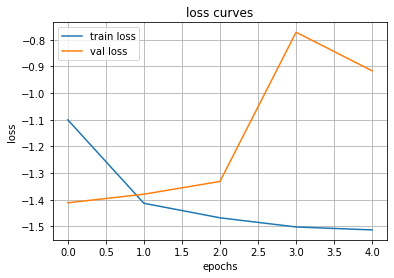

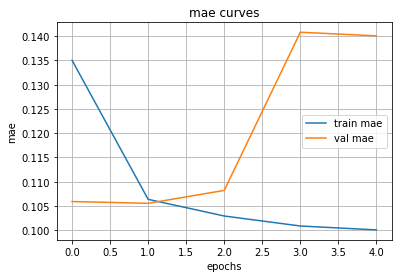

Train on 12750 samples, validate on 4250 samples
Epoch 1/5
12750/12750 - 1s - loss: -3.0427e-01 - mae: 0.3860 - val_loss: -9.5787e-01 - val_mae: 0.1749 - 701ms/epoch - 55us/sample
Epoch 2/5
12750/12750 - 1s - loss: -1.4003e+00 - mae: 0.1114 - val_loss: -1.4453e+00 - val_mae: 0.1081 - 517ms/epoch - 41us/sample
Epoch 3/5
12750/12750 - 1s - loss: -1.4917e+00 - mae: 0.1020 - val_loss: -1.4689e+00 - val_mae: 0.0998 - 532ms/epoch - 42us/sample
Epoch 4/5
12750/12750 - 1s - loss: -1.5229e+00 - mae: 0.0987 - val_loss: -1.2650e+00 - val_mae: 0.1039 - 506ms/epoch - 40us/sample
Epoch 5/5
12750/12750 - 1s - loss: -1.5383e+00 - mae: 0.0972 - val_loss: -1.0782e+00 - val_mae: 0.1140 - 528ms/epoch - 41us/sample


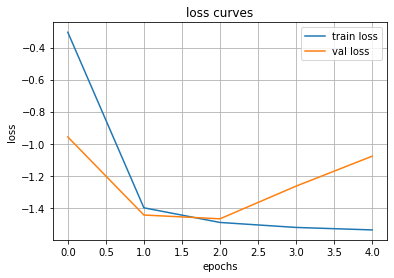

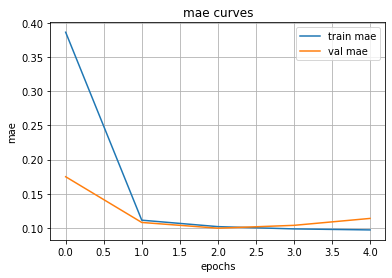

Train on 12750 samples, validate on 4250 samples
Epoch 1/5
12750/12750 - 1s - loss: -3.2753e-01 - mae: 0.3953 - val_loss: -4.3939e-01 - val_mae: 0.4000 - 651ms/epoch - 51us/sample
Epoch 2/5
12750/12750 - 1s - loss: -4.5058e-01 - mae: 0.3953 - val_loss: -4.5275e-01 - val_mae: 0.4000 - 520ms/epoch - 41us/sample
Epoch 3/5
12750/12750 - 1s - loss: -4.6072e-01 - mae: 0.3953 - val_loss: -4.3046e-01 - val_mae: 0.4000 - 535ms/epoch - 42us/sample
Epoch 4/5
12750/12750 - 1s - loss: -4.6557e-01 - mae: 0.3953 - val_loss: -4.3298e-01 - val_mae: 0.4000 - 516ms/epoch - 40us/sample
Epoch 5/5
12750/12750 - 1s - loss: -4.6955e-01 - mae: 0.3953 - val_loss: -4.0863e-01 - val_mae: 0.4000 - 524ms/epoch - 41us/sample


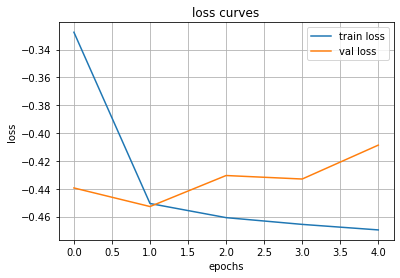

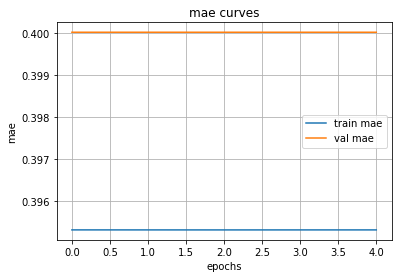

Train on 12750 samples, validate on 4250 samples
Epoch 1/5
12750/12750 - 1s - loss: -1.0096e+00 - mae: 0.1374 - val_loss: -1.1161e+00 - val_mae: 0.1302 - 663ms/epoch - 52us/sample
Epoch 2/5
12750/12750 - 1s - loss: -1.3537e+00 - mae: 0.1105 - val_loss: -1.3844e+00 - val_mae: 0.1011 - 544ms/epoch - 43us/sample
Epoch 3/5
12750/12750 - 1s - loss: -1.4305e+00 - mae: 0.1036 - val_loss: -1.2349e+00 - val_mae: 0.1077 - 544ms/epoch - 43us/sample
Epoch 4/5
12750/12750 - 1s - loss: -1.4775e+00 - mae: 0.0997 - val_loss: -1.2337e+00 - val_mae: 0.1057 - 551ms/epoch - 43us/sample
Epoch 5/5
12750/12750 - 1s - loss: -1.4933e+00 - mae: 0.0990 - val_loss: -5.8070e-01 - val_mae: 0.1487 - 526ms/epoch - 41us/sample


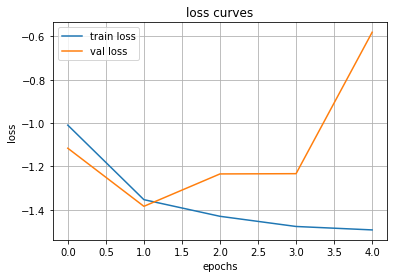

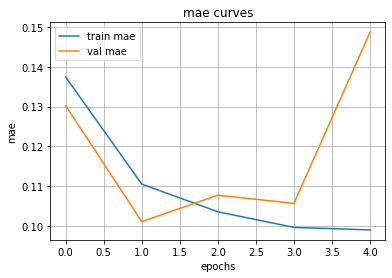

Train on 12750 samples, validate on 4250 samples
Epoch 1/5
12750/12750 - 1s - loss: -1.0432e+00 - mae: 0.1593 - val_loss: -1.3574e+00 - val_mae: 0.1144 - 713ms/epoch - 56us/sample
Epoch 2/5
12750/12750 - 1s - loss: -1.3674e+00 - mae: 0.1120 - val_loss: -1.3783e+00 - val_mae: 0.1097 - 546ms/epoch - 43us/sample
Epoch 3/5
12750/12750 - 1s - loss: -1.4105e+00 - mae: 0.1086 - val_loss: -1.3461e+00 - val_mae: 0.1072 - 536ms/epoch - 42us/sample
Epoch 4/5
12750/12750 - 1s - loss: -1.4406e+00 - mae: 0.1063 - val_loss: -1.3861e+00 - val_mae: 0.1047 - 545ms/epoch - 43us/sample
Epoch 5/5
12750/12750 - 1s - loss: -1.4609e+00 - mae: 0.1046 - val_loss: -1.2991e+00 - val_mae: 0.1054 - 518ms/epoch - 41us/sample


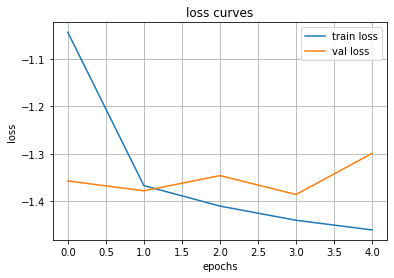

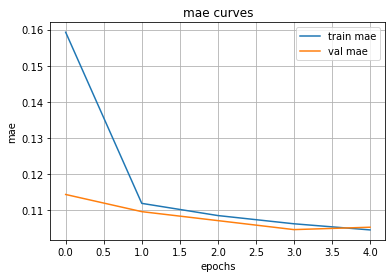

Saved estimator 0 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_5_num_estimators_5.h5/model-ensemble-0.hdf5
Saved estimator 1 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_5_num_estimators_5.h5/model-ensemble-1.hdf5
Saved estimator 2 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_5_num_estimators_5.h5/model-ensemble-2.hdf5
Saved estimator 3 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_5_num_estimators_5.h5/model-ensemble-3.hdf5
Saved estimator 4 to /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/ensemble_model_epochs_5_num_estimators_5.h5/model-ensemble-4.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


pred_samples shape  (5, 2, 3000, 1)
pred_mean shape  (2, 3000, 1)
pred_std shape  (2, 3000, 1)
prediction mean :
 [[[0.49015322]
  [0.26004156]
  [0.33697584]
  ...
  [0.13466406]
  [0.17655894]
  [0.73826313]]

 [[0.09210472]
  [0.04187797]
  [0.05739354]
  ...
  [0.02227884]
  [0.02774693]
  [0.23098055]]]
prediction mean shape  (2, 3000, 1)
prediction std :
 [[[0.24593052]
  [0.13452272]
  [0.17355359]
  ...
  [0.06990285]
  [0.08952706]
  [0.37043318]]

 [[0.14826365]
  [0.04402007]
  [0.07950653]
  ...
  [0.01274066]
  [0.01975471]
  [0.40249947]]]
prediction std shape  (2, 3000, 1)
training model summary 
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_28 (Dense)            (None, 32)                288       
                                 

In [ ]:
#obtained from hyperparameter optimization
def model_function():
    inp = Input(shape=(8,))
    x = Dense(32, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    mean = Dense(1, activation='relu')(x)
    var = Dense(1, activation='softplus')(x)

    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])
    #train_model.compile(loss='mse', optimizer='sgd', metrics=['mae'])   
    train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer='adam', metrics=['mae'])


    return train_model, pred_model 
        

# ENSEMBLE MODEL
def train_ensemble_model(model_func, x_train, y_train, x_val, y_val, x_test, epochs, num_estimators):
    K.clear_session()
    ens_model = SimpleEnsemble(model_func, num_estimators=num_estimators)
  
    # train a model with stochasticdropout() layer
    history = ens_model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)
    #saving the model that has custom layers
    ens_model.save(path+'ensemble_model_epochs_'+str(epochs)+'_num_estimators_'+str(num_estimators)+'.h5') 

    pred_samples, pred_mean, pred_std = ens_model.predict_output(x_test, num_ensembles=num_estimators)
    print('pred_samples shape ', pred_samples.shape)
    print('pred_mean shape ', pred_mean.shape)
    print('pred_std shape ', pred_std.shape)

    # return the predicted_samples, predicted_mean, predicted_std and model 
    return pred_mean, pred_std, ens_model

epochs=5
num_estimators=5

# running this command creates the stochastic dropout model, trains it and generates the predicted_samples, predicted_mean and predicted_std for the test set (all 3000 examples)
#prediction_samples, prediction_mean, prediction_std, ensemble_model = train_ensemble_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_estimators=num_estimators)
prediction_mean, prediction_std, ensemble_model = train_ensemble_model(model_function, train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_estimators=num_estimators)
print('prediction mean :\n', prediction_mean)
print('prediction mean shape ', prediction_mean.shape)
print('prediction std :\n', prediction_std)
print('prediction std shape ', prediction_std.shape)
#print('prediction samples :\n', prediction_samples)
#print('prediction samples shape ', prediction_samples.shape)
ensemble_model.summary()